In [12]:
import jax
jax.config.update("jax_default_device",jax.devices()[2])
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import jit,grad,jacfwd,jacrev,vmap
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from Kernels import *
from EquationModel import *
from jax.scipy.linalg import solve
from EquationModel import *
from GP_sampler import *
from plotting import *

In [13]:
# Define grid to get samples from GP
x_grid=jnp.linspace(0,1,25)
y_grid=jnp.linspace(0,1,25)
X,Y=jnp.meshgrid(x_grid,y_grid)
pairs = jnp.vstack([X.ravel(), Y.ravel()]).T

# Sample from GP m functions
kernel_GP = get_gaussianRBF(1.)
u_true_function1,u_true_function2, u_true_function3 = GP_sampler(num_samples = 3,
                                        X = pairs, 
                                        kernel = kernel_GP,
                                        reg = 1e-12,
                                        seed = 2024
                                    )  

# Permeability field A
def A(xy):
    x = xy[0]
    y = xy[1]
    return jnp.exp(jnp.sin(jnp.cos(x) + jnp.cos(y)))
# Compute f = Pu for any u
def get_rhs_darcy(u):
    def Agradu(xy):
        return A(xy)*jax.grad(u)(xy)
    def Pu(xy):
        return jnp.trace(jax.jacfwd(Agradu)(xy))
    return Pu

# Lists of m true u's and f's
u_true_functions = [u_true_function1,u_true_function2, u_true_function3]
rhs_funcs = [jax.vmap(get_rhs_darcy(u)) for u in u_true_functions]
vmapped_u_true_functions = [jax.vmap(u) for u in u_true_functions]

In [14]:
# Build interior and boundary grids
def build_xy_grid(x_range,y_range,num_grid_x,num_grid_y):
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    full_y_grid = jnp.linspace(y_range[0],y_range[1],num_grid_y)

    x_interior = full_x_grid[1:-1]
    y_interior = full_y_grid[1:-1]
    
    x_boundary = full_x_grid[jnp.array([0,-1])]
    y_boundary = full_y_grid[jnp.array([0,-1])]

    #Get interior points
    x,y = jnp.meshgrid(x_interior,y_interior)
    xy_interior = jnp.vstack([x.flatten(),y.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    x,y = jnp.meshgrid(x_interior,y_boundary)
    xy_boundary_1 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_interior)
    xy_boundary_2 = jnp.vstack([x.flatten(),y.flatten()]).T

    x,y = jnp.meshgrid(x_boundary,y_boundary)
    xy_boundary_3 = jnp.vstack([x.flatten(),y.flatten()]).T

    xy_boundary = jnp.vstack([xy_boundary_1,xy_boundary_2,xy_boundary_3])
    return xy_interior,xy_boundary

In [16]:
# Define the observed points for each u
num_grid_points = 12
# Ghost grid - Same per function
xy_int,xy_bdy = build_xy_grid([0,1],[0,1],num_grid_points,num_grid_points)
xy_all = jnp.vstack([xy_bdy,xy_int])


u_true1, u_true2, utrue3 = [fn(xy_all) for fn in vmapped_u_true_functions]


def get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, vmapped_rhs, seed):
    """
        Gets samples(functions) of GP. 

        Args:
            num_obs (list): List of integers of number of observed points per function.
            xy_int (jnp.array): Interior domain to get the sample.
            xy_bdy (jnp.array): Boundary domain.
            vmapped_u_true_functions (list): List of vmapped u true functions.
            vmapped_u_true_functions (list): List of vmapped f true functions.
            seed (int): Integer to fix the simulation.

        Returns:
            list: List of lists xy_obs, u_obs, f_obs.   
    """

    if len(num_obs) != len(vmapped_u_true_functions):
        raise Exception("len of list of provided observed points not same as len of list of provided functions.")
    
    num_f = len(vmapped_rhs)
    key = jax.random.PRNGKey(seed)
    seed = jax.random.randint(key=key, shape=(num_f,), minval=1, maxval=40)
    xy_obs, u_obs, f_obs =  [], [], []
    for i, num_ob in enumerate(num_obs):
        xy_sample_indsi = np.random.choice(list(np.arange(len(xy_int))),num_ob,replace = False)
        xy_obsi = jnp.vstack([xy_bdy,xy_int[xy_sample_indsi]])
        xy_obs.append(xy_obsi)
        u_obs.append(vmapped_u_true_functions[i](xy_obsi))
        f_obs.append(rhs_funcs[i](xy_obsi))
    return xy_obs, u_obs, f_obs

# Number of observed points per u
num_obs = [3,4,2]

xy_obs, u_obs, f_obs = get_obs(num_obs, xy_int, xy_bdy,vmapped_u_true_functions, rhs_funcs, seed=2024)

xy_obs1,xy_obs2,xy_obs3 = xy_obs
u_obs1,u_obs2,u_obs3 = u_obs
f_obs1,f_obs2,f_obs3 = f_obs

In [27]:
# Define fine grid to plot
num_fine_grid = 100
x_fine,y_fine = np.meshgrid(np.linspace(0,1,num_fine_grid),np.linspace(0,1,num_fine_grid))
xy_fine = np.vstack([x_fine.flatten(),y_fine.flatten()]).T

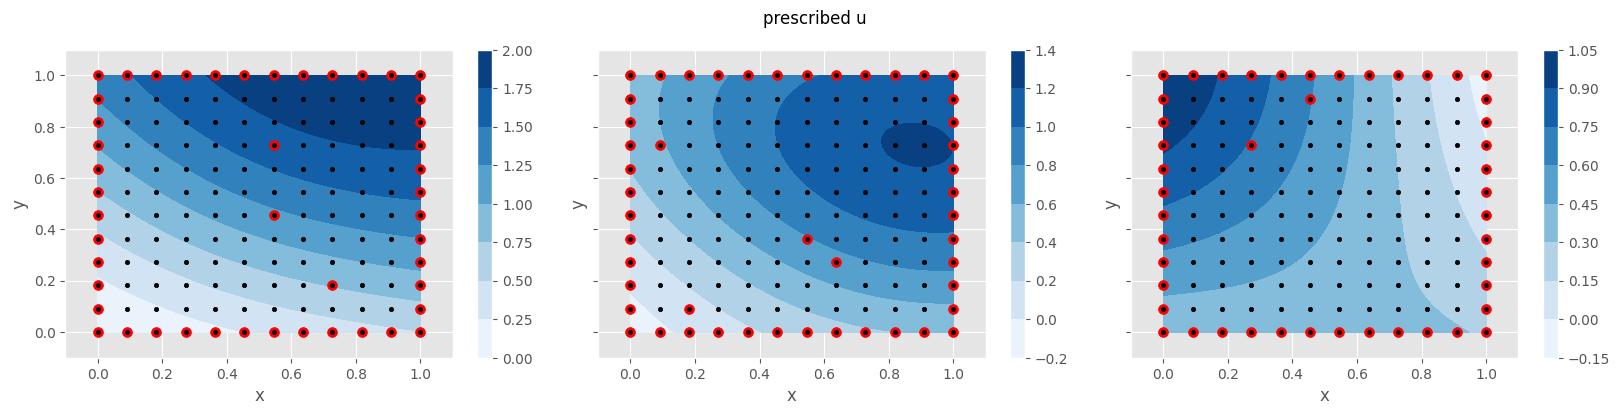

In [30]:
# Plot u's
plot_obs(xy_fine, xy_all, xy_obs, vmapped_u_true_functions, title = 'prescribed u')

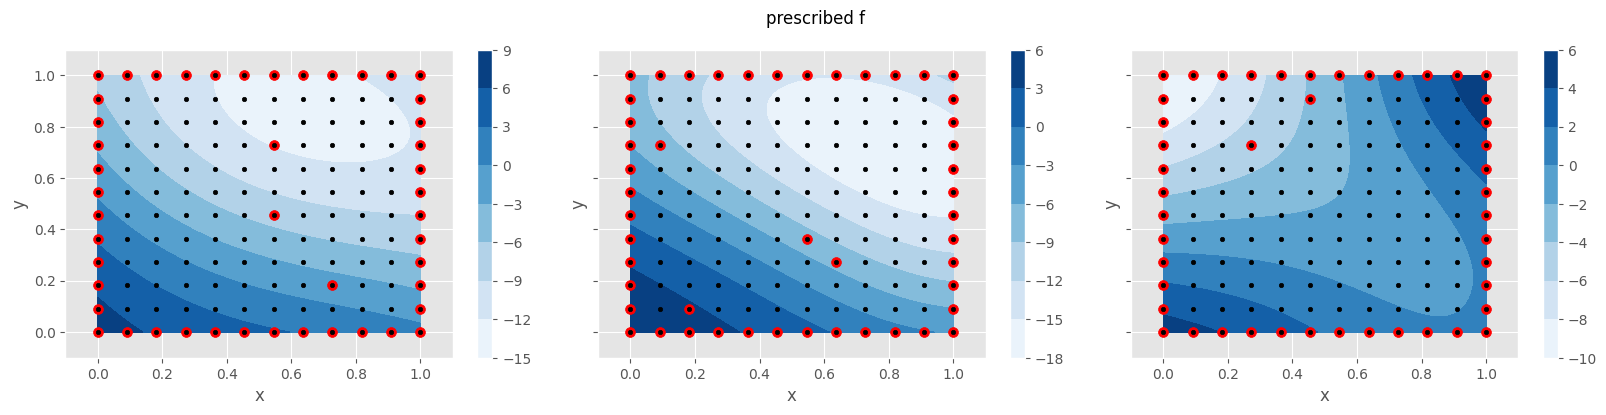

In [31]:
# Plot f's
plot_obs(xy_fine, xy_all, xy_obs, rhs_funcs, title = 'prescribed f')

In [19]:
def get_ux(u):
    def ux(x):
        return jax.grad(u)(x)[0]
    return jax.vmap(ux)

def get_uy(u):
    def uy(x):
        return jax.grad(u)(x)[1]
    return jax.vmap(uy)

In [20]:
u1x = get_ux(u_true_function1)

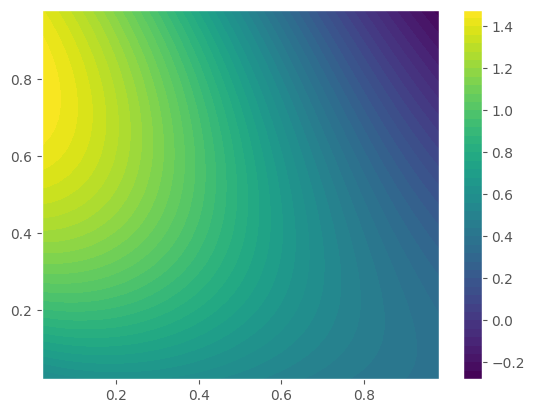

In [21]:
plt.tricontourf(xy_int[:,0],xy_int[:,1],u1x(xy_int),50)
plt.colorbar()